In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt

from results_from_metaspace_msms_process import reporting_loop
from results_processing_on_dl_results import annotate_cos_parent_fragment
from results_processing_on_dl_results import spectral_encoder
from results_processing_on_dl_results import ref_spectra_encoder

This notebook will a) download an existing METASPACE MS/MS report from the server provided ds_id and db_id and then b) generate psuedo-MS/MS spectra from the report, and c) compare them versus reference MS/MS from core_metabolome_v3

Generally, a user will only need to update the first 6 variables in 
in cell "## 2. Download METASPACE MS/MS report from METASPACE" to 
execute.  

Graph output is a) printed to notebook b) saved to local directory, 
and c) returned as variable from plotting function.

In [37]:
## 0. Metaspace credentials need to be local machine at path below
## with format shown:
path = "/Users/dis/.metaspace.json"
format_of_json = {"email": "<email>",
                  "password": "<password>",
                  "api_key": "<api_key>"}

In [38]:
## 1. Obtain eference spectra from core_metabolome_v3
# Generated here: http://localhost:8889/notebooks/PycharmProjects/word2vec/trees_to_msms_df.ipynb
ref_spectra_df = pd.read_pickle("input/cm3_reference_spectra_df.pickle")

In [39]:
## 2. Download METASPACE MS/MS report from METASPACE
# Dependency: 

# Replace variables below for your dataset!
original_ds_id_on_prod = '2020-03-12_17h55m21s'  # Update to run!
db_id_on_beta = '2020-05-13_17h50m21s'  # Update to run!
ds_id_on_beta = '2020-05-14_16h32m01s'  # Update to run!
path_to_reports = 'TEMP/reporting/'  # Update to run!
polarity = ['positive', 'negative'][0]  # Update to run!
psuedo_y_axis = ['binary', 'fdr', 'msm', 'cos', 'intensity'][0]

# Download results
reporting_loop(original_ds_id_on_prod,
               db_id_on_beta,
               ds_id_on_beta,
               path_to_reports,
               parent_and_fragment_req=True,
               fdr_max=0.5,
               save_image=False)

# Annotate results with cosine similarity
df_path = glob.glob(path_to_reports + ds_id_on_beta + "/*.pickle")[0]
df = pd.read_pickle(df_path)
df = annotate_cos_parent_fragment(path_to_reports,
                                  [ds_id_on_beta], 
                                  df_path)

2020-05-14_16h32m01s  Counter:  11
1   2020-05-14_16h32m01s


In [40]:
## 3. Generate psuedo-MS/MS spectra from ISF data.
ds_spectra_dict = {}
par_df = df[df.par_or_frag == 'P'].copy(deep=True)
par_df['psuedo_msms'] = par_df.apply(lambda x: spectral_encoder(df,
                                                               x.ds_id,
                                                               x.id_x,
                                                               psuedo_y_axis),
                                    axis=1
                                    ) 
par_df['polarity'] = polarity

In [41]:
def assign_adduct(formula, polarity):
    # Assigns adduct for METASPACE MS/MS results.
    # Only supports: ['M-H-', 'M+H+', 'M+K+', 'M+Na+']
    if polarity == "negative":
        return 'M-H-'
    elif formula.find('Na') == True:
        return 'M+Na+'
    elif formula.find('K') == True:
        return 'M+K+'
    else:
        return 'M+H+'

In [42]:
## 4. Find matches between psuedo-MS/MS and reference MS/MS spectra
par_df['adduct'] = par_df.apply(lambda x: assign_adduct(x.formula, 
                                                        x.polarity), 
                                axis=1)
par_df = par_df.rename(columns={"id_x":'id'})

temp_df = ref_spectra_df[ref_spectra_df.id.isin(list(par_df.id))]
temp_df = temp_df[temp_df.polarity == par_df.polarity[0]]

df1 = par_df[['id', 'adduct', 'psuedo_msms', 'polarity', 'ds_id']].copy(deep=True)
df2 = temp_df[['id', 'adduct', 'spectra']]
to_plot_df = df1.merge(df2, how="left", on=['id', 'adduct'])

In [43]:
to_plot_df

,id,adduct,psuedo_msms,polarity,ds_id,spectra
0,HMDB0010382,M+H+,"[(104.10695125566524, 1), (184.07328163766385,...",positive,2020-05-14_16h32m01s,"[(98.985107, 624.0), (104.107414, 5604.0), (12..."
1,HMDB0008578,M+H+,"[(104.10695125566524, 1), (184.07328163766385,...",positive,2020-05-14_16h32m01s,"[(86.09697, 15.0), (104.10753000000001, 15.0),..."


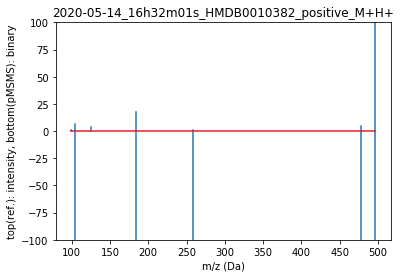

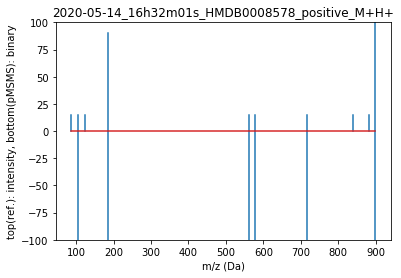

In [46]:
## 5. Plot psuedo-MS/MS and reference MS/MS spectra

def plot_spectra(df, out_path, psuedo_y_axis):
    # Plots mirrored MS/MS spectra!
    
    ref = list(df.spectra)
    test = list(df.psuedo_msms)
    
    mzs = [x[0] for x in ref] + [x[0] for x in test]
    
    y_ref = [x[1] for x in ref]
    y_test = [x[1] for x in test]
    
    y_ref_norm = [x/max(y_ref)*100 for x in y_ref]
    y_test_norm = [x/max(y_test)*-100 for x in y_test]
    
    ys = y_ref_norm + y_test_norm
    
    title = df.ds_id + "_" + df.id + "_" + df.polarity + "_" + df.adduct
    
    fig, ax = plt.subplots()
    ax.stem(mzs, ys ,markerfmt=' ')
    plt.title(title)
    plt.xlabel('m/z (Da)')
    plt.ylabel("top(ref.): intensity, bottom(pMSMS): " + psuedo_y_axis)
    plt.ylim((-100, 100))
    plt.savefig(out_path + title)
    plt.show()
    return fig, ax


plots = to_plot_df.apply(lambda x: plot_spectra(x,
                                                "temp/spectra",
                                                psuedo_y_axis), axis=1)

In [47]:
plots

0    (Figure(432x288), AxesSubplot(0.125,0.125;0.77...
1    (Figure(432x288), AxesSubplot(0.125,0.125;0.77...
dtype: object